In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from collections import defaultdict
from abc import abstractmethod, ABC

@dataclass
class Gridworld:
    shape: tuple = (10, 20)
    start: tuple = (5, 0)
    goal: tuple = (5, 16)
    wind: list[int] = field(default_factory = lambda: [0]*9+[1]*3+[2]*4+[1]*2+[0]*2)

    def __post_init__(self):
        assert len(self.wind)==self.shape[1]

    def bounds_and_wind(self, state):
        state_after_bounds = self.fix_bounds(state)
        state_after_wind = self.apply_wind(state_after_bounds)
        state_after_bounds = self.fix_bounds(state_after_wind)
        return state_after_bounds, self.check_goal(state_after_bounds)
    
    def apply_wind(self, state):
        return [state[0]+ self.wind[state[1]],state[1]]
    
    def check_goal(self, state):
        return tuple(state) == self.goal
    
    def fix_bounds(self, state):
        if state[0] < 0:
            state[0] = 0
        if state[0] >= self.shape[0]:
            state[0] = self.shape[0]-1

        if state[1] < 0:
            state[1] = 0
        if state[1] >= self.shape[1]:
            state[1] = self.shape[1]-1
        return state
    
    def plot_world(self, states = []):
        world = np.zeros(self.shape)
        for i, w in enumerate(self.wind):
            world[:, i] = w

        fig = plt.figure(figsize=(9, 5))
        ax = fig.add_subplot(111)
        h = ax.imshow(world, aspect='equal', cmap='Greys', origin='lower') 
        ax.scatter(self.start[1], self.start[0], color='red', marker='o', s=100, label='Start')
        ax.scatter(self.goal[1], self.goal[0], color='green', marker='o', s=100, label='Goal')
        cbar = fig.colorbar(h, ax=ax)      
        cbar.set_label('Wind Up')
        cbar.set_ticks(range(min(self.wind), max(self.wind)+1))

        ax.set_xticks(np.arange(-0.5, self.shape[1], 1))
        ax.set_yticks(np.arange(-0.5, self.shape[0], 1))
        ax.grid(which='both', color='black', linestyle='-', linewidth=1)
        if states:
            for i, state in enumerate(states[:-1]):
                if state == states[i+1]:
                    continue
                ax.text(state[1], state[0], f'{i+1}', ha='center', va='center', color='blue')
            state = states[-1]
            ax.text(state[1], state[0], f'{i+2}', ha='center', va='center', color='blue')
        
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        fig.legend()

@dataclass
class GridworldStochasticWind(Gridworld):
    def apply_wind(self, state):
        if self.wind[state[1]] == 0:
            return state
        modif = np.random.choice([-1, 0, 1], p=[1/3, 1/3, 1/3])
        return [state[0]+ self.wind[state[1]]+modif,state[1]]



class Agent:
    def __init__(self, alpha = 0.1, epsilon = 0.1, gamma = 1, terminal_state = (7, 16)):
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.q_val = defaultdict(lambda: np.random.uniform(0, 10))
        self.terminal_state = terminal_state
        self.actions = [[-1, 0], [1, 0], [0, -1], [0, 1]]
        for i in range(len(self.actions)):
            self.q_val[self.terminal_state, i] = 0

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(range(len(self.actions)))
        else:
            return np.argmax([self.q_val[state, action] for action in range(len(self.actions))])
        
    def apply_action(self, state, action):
        return [state[0] + self.actions[action][0], state[1] + self.actions[action][1]]
        
    def update_q_val(self, state, action, reward, next_state, next_action):
        self.q_val[state, action] += self.alpha * (reward + self.gamma * self.q_val[next_state, next_action] - self.q_val[state, action])

class AgentMoreActions(Agent):
    def __init__(self, alpha = 0.1, epsilon = 0.1, gamma = 1, terminal_state = (7, 16)):
        super().__init__(alpha, epsilon, gamma, terminal_state)
        self.actions = [[-1, 0], [1, 0], [0, -1], [0, 1], [-1, -1], [-1, 1], [1, -1], [1, 1]]
        for i in range(len(self.actions)):
            self.q_val[self.terminal_state, i] = 0

class AgentEvenMoreActions(AgentMoreActions):
    def __init__(self, alpha = 0.1, epsilon = 0.1, gamma = 1, terminal_state = (7, 16)):
        super().__init__(alpha, epsilon, gamma, terminal_state)
        self.actions = [[-1, 0], [1, 0], [0, -1], [0, 1], [-1, -1], [-1, 1], [1, -1], [1, 1], [0, 0]]
        for i in range(len(self.actions)):
            self.q_val[self.terminal_state, i] = 0
        

# plot world

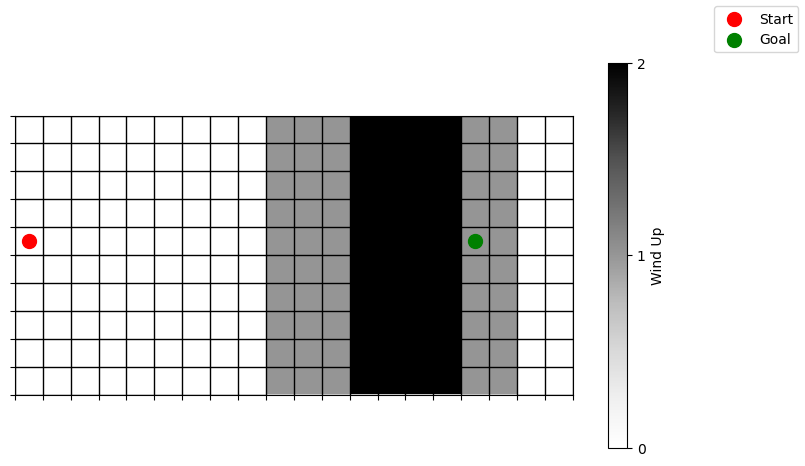

In [2]:
world = Gridworld()
world.plot_world()

# Sarsa

In [3]:
from tqdm import tqdm

def run_gridworld_agent(world, agent, n_episodes):
    episode_rewards = []
    for episode in tqdm(range(n_episodes)):
        temp_rewards = []
        state = list(world.start)
        action = agent.choose_action(tuple(state))
        finished = False
        while not finished:
            next_state = agent.apply_action(state, action)
            next_state, finished = world.bounds_and_wind(next_state)
            reward = -1
            next_action = agent.choose_action(tuple(next_state))
            agent.update_q_val(tuple(state), action, reward, tuple(next_state), next_action)
            state = next_state
            action = next_action
            temp_rewards.append(reward)
        episode_rewards.append(sum(temp_rewards))

    plt.figure()
    plt.plot(np.log(np.abs(episode_rewards)))
    plt.xlabel('Episode')
    plt.ylabel('Log Abs Reward')

    state = list(world.start)
    states = []
    finished = False
    agent.epsilon = 0
    while not finished:
            action = agent.choose_action(tuple(state))
            next_state = agent.apply_action(state, action)
            next_state, finished = world.bounds_and_wind(next_state)
            states.append(next_state)
            state = next_state
            action = next_action

    world.plot_world(states)

## base case

100%|██████████| 10000/10000 [00:04<00:00, 2116.74it/s]


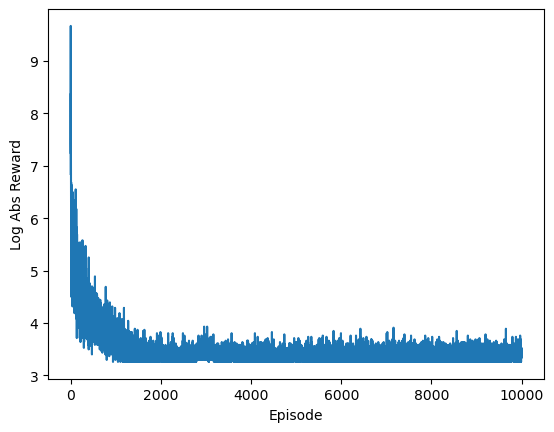

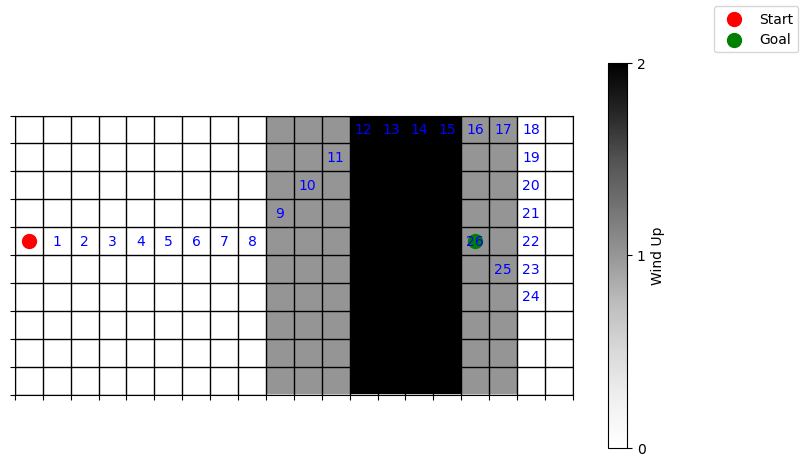

In [4]:
n_episodes = 10000
world = Gridworld()
agent = Agent()

run_gridworld_agent(world, agent, n_episodes)

## extra actions

100%|██████████| 20000/20000 [00:07<00:00, 2584.20it/s]


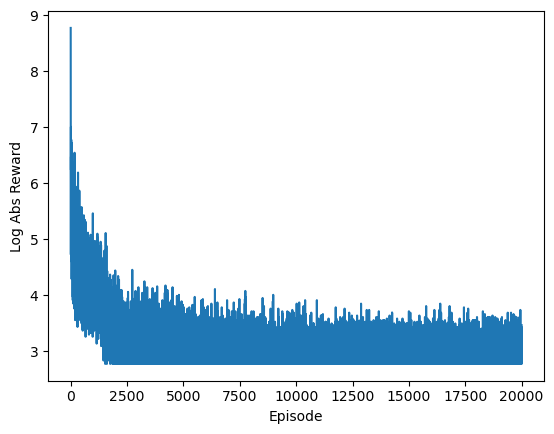

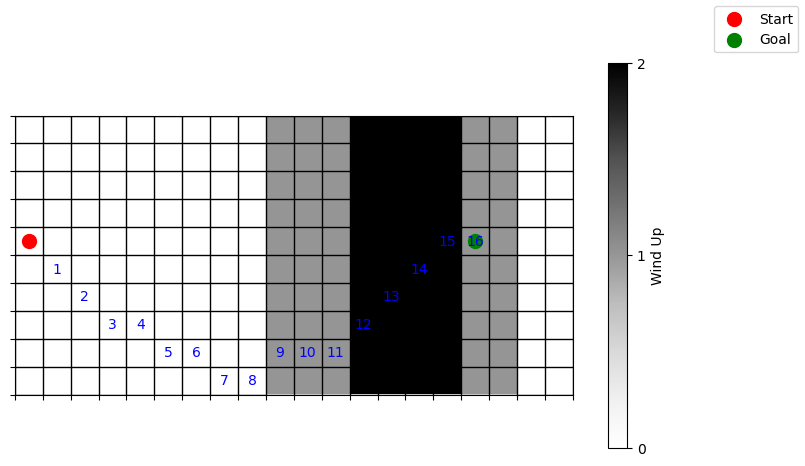

In [5]:
n_episodes = 20000
world = Gridworld()
agent = AgentMoreActions()

run_gridworld_agent(world, agent, n_episodes)

## even more actions

100%|██████████| 20000/20000 [00:08<00:00, 2453.39it/s]


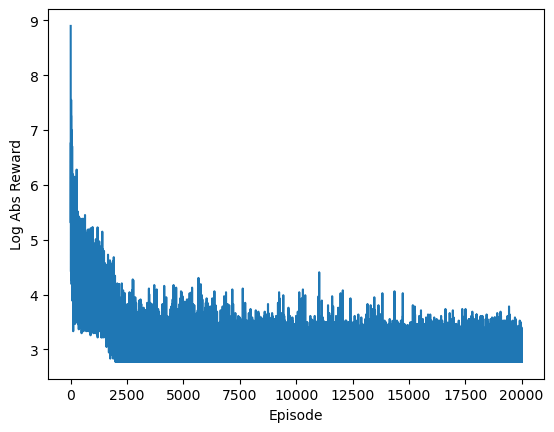

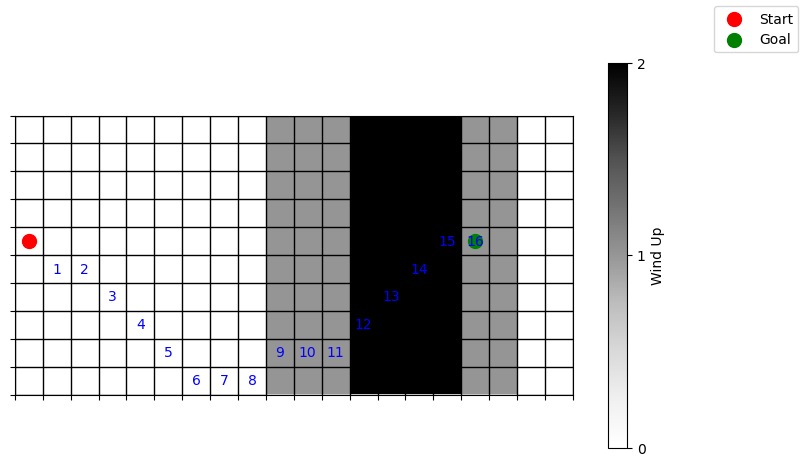

In [6]:
n_episodes = 20000
world = Gridworld()
agent = AgentEvenMoreActions()

run_gridworld_agent(world, agent, n_episodes)

# Stochastic wind

## default actions

100%|██████████| 10000/10000 [00:13<00:00, 743.92it/s]


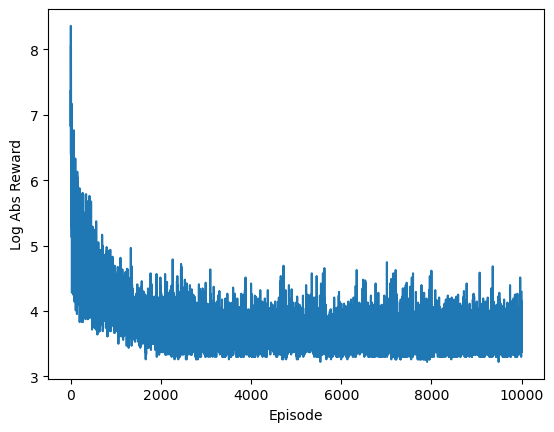

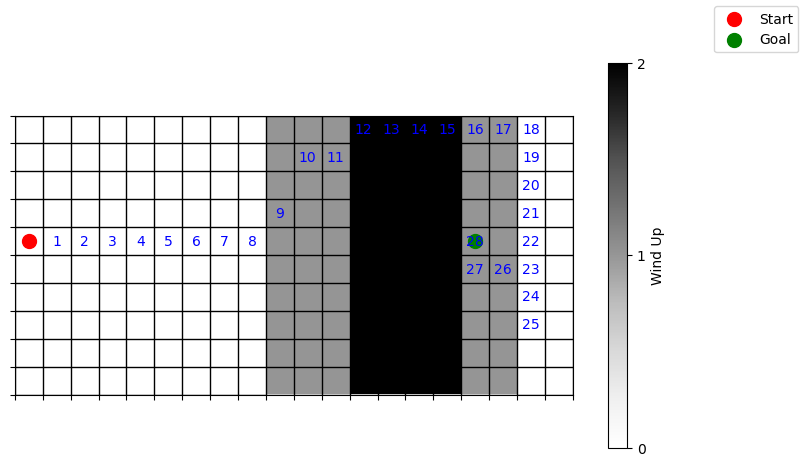

In [7]:
n_episodes = 10000
world = GridworldStochasticWind()
agent = Agent()

run_gridworld_agent(world, agent, n_episodes)

## more actions

100%|██████████| 20000/20000 [00:21<00:00, 930.81it/s] 


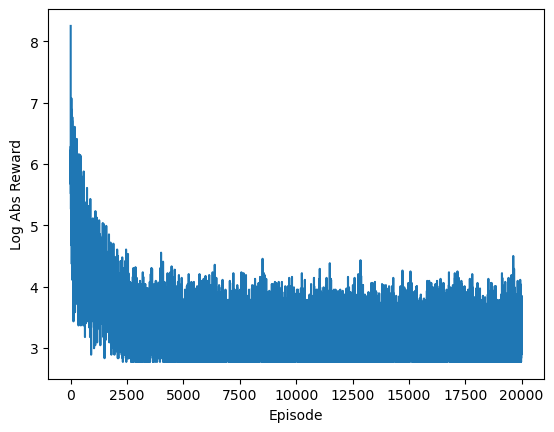

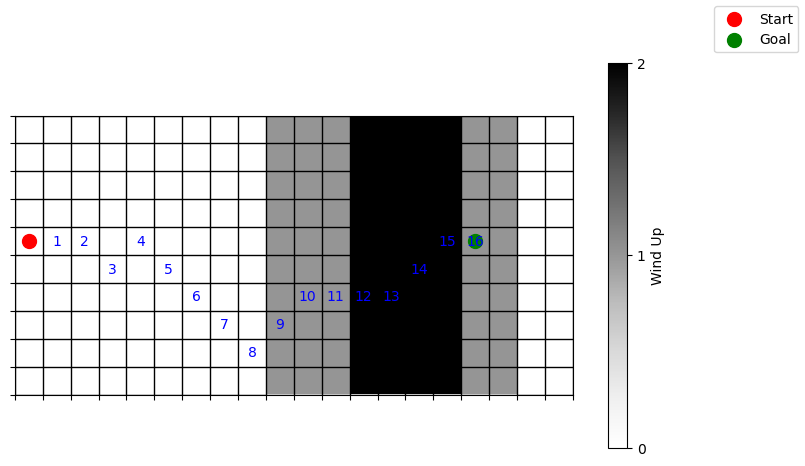

In [8]:
n_episodes = 20000
world = GridworldStochasticWind()
agent = AgentMoreActions()

run_gridworld_agent(world, agent, n_episodes)

## even more actions

100%|██████████| 20000/20000 [00:19<00:00, 1015.03it/s]


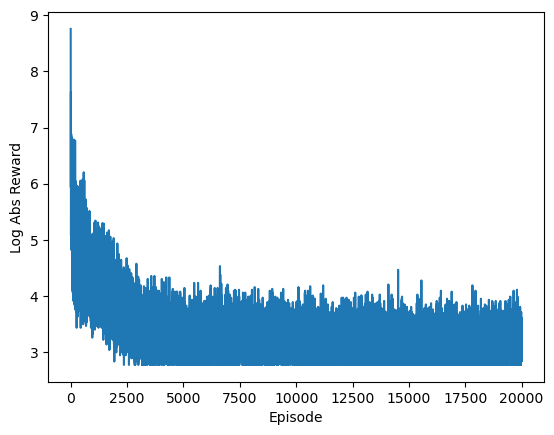

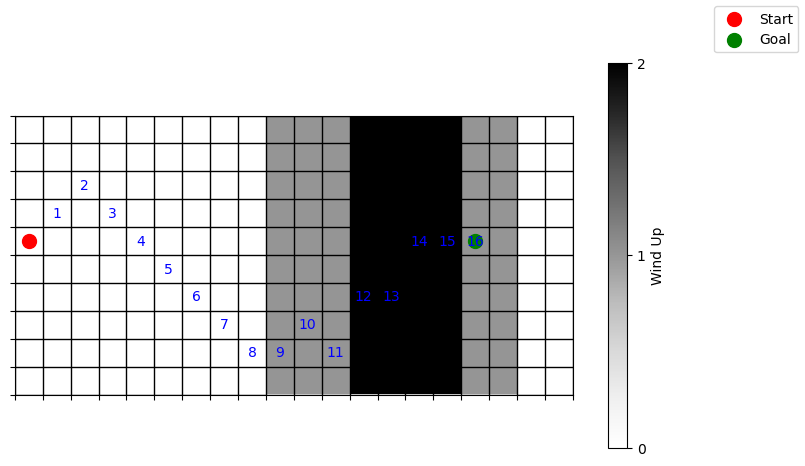

In [9]:
n_episodes = 20000
world = GridworldStochasticWind()
agent = AgentEvenMoreActions()

run_gridworld_agent(world, agent, n_episodes)